In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sodapy import Socrata
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates
from matplotlib.ticker import StrMethodFormatter

In [4]:
allegation = pd.read_csv('data/data_allegation.csv')
allegation.incident_date = pd.to_datetime(allegation.incident_date)

geocoordinates = pd.read_csv('data/geocoordinates.csv')
geocoordinates['geometry'] = geocoordinates.apply(lambda x: Point(float(x.x), float(x.y)), axis=1)
geocoordinates = gpd.GeoDataFrame(geocoordinates)

officer_allegation = pd.read_csv('data/data_officerallegation.csv')

category = pd.read_csv('data/data_allegationcategory.csv')

/Users/eliasserrania/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/eliasserrania/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
crids = allegation[(allegation.incident_date >= '2010-01-01 00:00:00') & (allegation.incident_date < '2018-01-01 00:00:00')].crid
geocoordinates = geocoordinates[geocoordinates.crid.isin(crids)]
allegation = allegation[allegation.crid.isin(crids)]
officer_allegation = officer_allegation[officer_allegation.allegation_id.isin(crids)]
officer_allegation = officer_allegation.merge(category, how='left', left_on='allegation_category_id', right_on='id')

In [6]:
officer_allegation.groupby('category').size().sort_values(ascending=False)

category
Operation/Personnel Violations    12244
Use Of Force                       6988
Illegal Search                     6806
False Arrest                       3697
Lockup Procedures                  2642
Domestic                           1136
Traffic                             844
Verbal Abuse                        838
Conduct Unbecoming (Off-Duty)       811
Criminal Misconduct                 341
Supervisory Responsibilities        242
Money / Property                    239
Drug / Alcohol Abuse                211
Bribery / Official Corruption       150
Unknown                              52
Excessive Force                      24
Medical                              15
Racial Profiling                      9
First Amendment                       6
dtype: int64

Text(0.5,1,'Most common allegation types\nChicago 2010-2017')

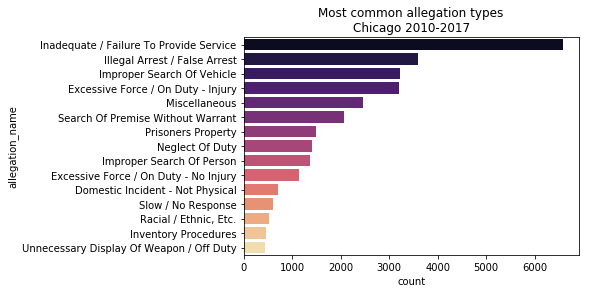

In [7]:
sns.countplot(data=officer_allegation, y='allegation_name', 
              order=officer_allegation.allegation_name.value_counts().iloc[:15].index,
              palette='magma')
plt.title('Most common allegation types\nChicago 2010-2017')

In [8]:
officer_allegation.groupby('allegation_name').size().sort_values(ascending=False).head(10)

allegation_name
Inadequate / Failure To Provide Service    6576
Illegal Arrest / False Arrest              3584
Improper Search Of Vehicle                 3214
Excessive Force / On Duty - Injury         3195
Miscellaneous                              2457
Search Of Premise Without Warrant          2066
Prisoners Property                         1481
Neglect Of Duty                            1402
Improper Search Of Person                  1369
Excessive Force / On Duty - No Injury      1132
dtype: int64

In [9]:
client = Socrata("data.cityofchicago.org", None)
results = client.get("74p9-q2aq", limit=1000000)
tracts = pd.DataFrame.from_records(results)
tracts['geometry'] = tracts.apply(lambda x: Polygon(x.the_geom.get('coordinates')[0][0]), axis=1)
tracts = gpd.GeoDataFrame(tracts).drop(columns=['the_geom'])

In [10]:
allegations_tract = gpd.sjoin(tracts, geocoordinates, how="left")

/Users/eliasserrania/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [11]:
by_tract = allegations_tract.groupby('tractce10').size().to_frame().rename({0: 'number_allegations'}, axis='columns')
by_tract = tracts.merge(by_tract, how='left', on='tractce10')

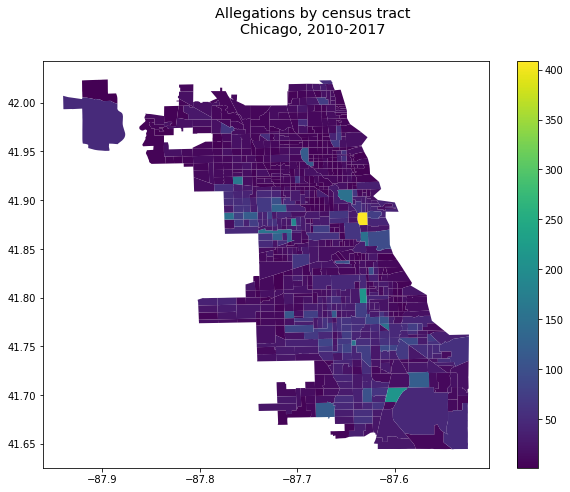

In [12]:
f, ax = plt.subplots(1, figsize=(10, 7.5))
ax = by_tract.plot(column='number_allegations', legend=True, ax=ax)
f.suptitle('Allegations by census tract\nChicago, 2010-2017', fontsize='x-large')
plt.show()

In [13]:
byyear = allegation.groupby(pd.Grouper(key='incident_date', freq='YS')).size().to_frame().\
    rename({0: 'allegations'},axis='columns').reset_index()

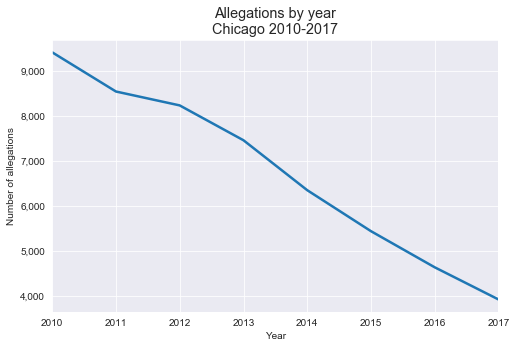

In [14]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8, 5))
g = sns.lineplot(x='incident_date', y='allegations',
                 data=byyear, ax=ax,
                 linewidth=2.5, palette='GnBu_d')
    
ax.set(xlim=('12/31/2009','01/2017'),
           xlabel='Year', ylabel='Number of allegations')
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y"))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
ax.set_title('Allegations by year\nChicago 2010-2017', fontsize='x-large')
plt.show()